In [1]:
# logging 
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [2]:
# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_woods

maze = gym.make('Woods1-v0')
print("This is how maze looks like")
situation = maze.reset()
print(type(situation))
print(situation)
maze.render()

This is how maze looks like
<class 'list'>
['.', 'O', 'O', 'O', '.', '.', '.', '.']

□ □ □ □ □
□ ■ ■ $ □
X ■ ■ ■ □
□ ■ ■ ■ □
□ □ □ □ □


In [3]:
from lcs.agents.xncs import XNCS, Configuration

def cl_accuracy(cl, cfg):
     if cl.error < cfg.epsilon_0:
        return 1
     else:
        return cfg.alpha * pow(1/(cl.error * cfg.epsilon_0), cfg.v)
            
def fraction_accuracy(xncs):
    action_sets_percentages = []
    for action in range(xncs.cfg.number_of_actions):
        action_set = xncs.population.generate_action_set(action)
        total_accuracy = 0
        most_numerous = action_set[0]
        for cl in action_set:
            total_accuracy += cl_accuracy(cl, xncs.cfg)
            if cl.numerosity > most_numerous.numerosity:
                most_numerous = cl
        action_sets_percentages.append(cl_accuracy(most_numerous, xncs.cfg) / total_accuracy)
    return sum(action_sets_percentages) / xncs.cfg.number_of_actions

def specificity(xncs, population):
    total_specificity = 0
    for cl in population:
        total_specificity += pow(2, cl.wildcard_number)
    return total_specificity / xncs.population.numerosity

def xcs_maze_metrics(xncs: XNCS, environment):
    return {
        'numerosity': xncs.population.numerosity,
        'population': len(xncs.population),
        'average_specificity': specificity(xncs, xncs.population),
        'fraction_accuracy': fraction_accuracy(xncs)
    }

In [4]:
cfg = Configuration(number_of_actions=8,
                    max_population=1800,
                    learning_rate=0.2,
                    mutation_chance=0.08,
                    chi=0.8,
                    ga_threshold=25,
                    deletion_threshold=25,
                    delta=0.1,
                    initial_error=0.01,
                    metrics_trial_frequency=50,
                    covering_wildcard_chance = 0.9,
                    user_metrics_collector_fcn=xcs_maze_metrics,
                    lmc=10,
                    lem=200)

In [5]:
agent = XNCS(cfg)
explore_population, explore_metrics = agent.explore(maze, 1000, False)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 5, 'reward': [0, 0, 0, 0, 0, 1.9621374957174576e-77, 0, 200.0], 'numerosity': 40, 'population': 40, 'average_specificity': 2.175, 'fraction_accuracy': 0.19999999999999998}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 47, 'reward': [9.818205450857175, 12.785216085030484, 12.704276101595902, 37.09685602654463, 26.329943134081496, 212.39782865151173, 9.901812878544018, 19.615294297476844], 'numerosity': 270, 'population': 127, 'average_specificity': 2.1148148148148147, 'fraction_accuracy': 1.510937574321998e-10}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 16, 'reward': [10.02037240685338, 25.50322254093299, 6.146545450743708, 33.00149028778198, 30.68237010054218, 18.168728212803426, 7.900157230260672, 209.7126793314473], 'numerosity': 290, 'population': 128, 'average_specificity': 2.0482758620689654, 'fraction_accuracy': 0.03652859025202316}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 23, 'reward': [5.584

In [6]:
for cl in explore_population:
    print(str(cl))

Cond:O....#.O - Act:0 - Num:3 [fit: 0.000001, exp: 54.00, pred: 210.549, error:33.86656309293582]
Cond:#....#.# - Act:1 - Num:3 [fit: 0.000000, exp: 214.00, pred: 238.345, error:392.3247566068967]
Cond:O#.#...O - Act:2 - Num:3 [fit: 0.000000, exp: 122.00, pred: 188.056, error:639.1842656469657]
Cond:O.##...O - Act:3 - Num:3 [fit: 0.000000, exp: 126.00, pred: 200.356, error:31.393460677310184]
Cond:#.#.#O.O - Act:4 - Num:3 [fit: 0.000083, exp: 31.00, pred: 436.808, error:361.05729082806056]
Cond:O....O.O - Act:5 - Num:3 [fit: 0.040960, exp: 5.00, pred: 344.398, error:77.76953572708335]
Cond:#......O - Act:6 - Num:3 [fit: 0.000000, exp: 156.00, pred: 245.424, error:442.4360999256011]
Cond:O...#..O - Act:7 - Num:3 [fit: 0.000000, exp: 138.00, pred: 194.801, error:44.46973853504226]
Cond:.#.#O#.# - Act:0 - Num:3 [fit: 0.000000, exp: 158.00, pred: 188.222, error:261.2192660822129]
Cond:...FO#.. - Act:1 - Num:3 [fit: 0.000000, exp: 65.00, pred: 187.629, error:27.91529937677003]
Cond:..#FOO..

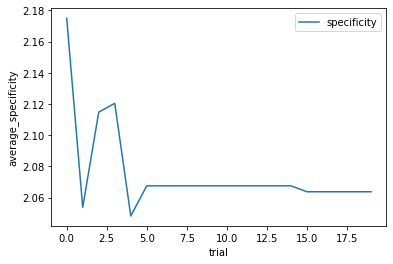

In [7]:
import pandas as pd
import numpy as np

df = pd.DataFrame(metric["average_specificity"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("average_specificity")
ax.legend(["specificity"])


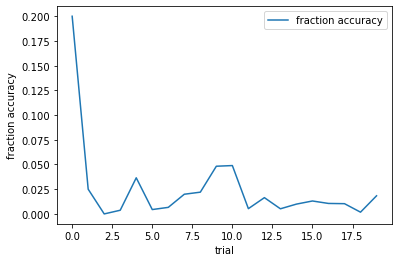

In [8]:
df = pd.DataFrame(metric["fraction_accuracy"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("fraction accuracy")
ax.legend(["fraction accuracy"])


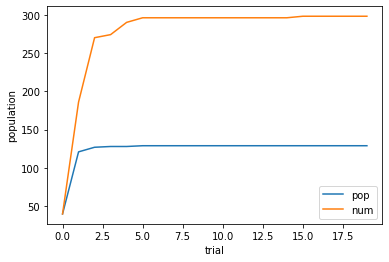

In [9]:

df = pd.DataFrame(zip([metric["population"] for metric in explore_metrics], [metric["numerosity"] for metric in explore_metrics]))
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["pop", "num"])

steps_averaged = []


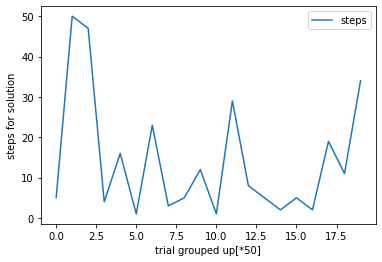

In [10]:


xf = [metric["steps_in_trial"] for metric in explore_metrics]
temp_df = np.array_split(xf, 20)
for i in range(len(temp_df)):
    temp_df[i] = np.mean(temp_df[i]) 
df = pd.DataFrame(temp_df)
# df = pd.DataFrame(metric["steps_in_trial"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial grouped up[*50]")
ax.set_ylabel("steps for solution")
ax.legend(["steps"])
